## Problem description

In this project, we tackle the binary classification problem of detecting whether a given tweet is related to a disaster or not. Each tweet may contain informal language, abbreviations, hashtags, mentions, URLs, emojis, and other noisy content typical of social media, making this a challenging natural language processing task.

##### Project Objectives

- Train and compare different LSTM architectures for binary classification.

- Evaluate model performance using F1-Score and other metrics like AUC.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data description
The data is donwloaded from https://www.kaggle.com/competitions/nlp-getting-started/data competition. It is composed by the following files:
- Train: Contains the tweet in text and the label, also the location and keyword.
- Test folder: Contains the tweet in text, location and keyword, but not the label.
- sample_submission.csv: Is the file as example of the sumbission that we need to upload.

Let's explore each of them:

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [3]:
print('Train shape:')
print(train.shape)
print('Test shape:')
print(test.shape)
print('Sample submission shape:')
print(sample_submission.shape)

Train shape:
(7613, 5)
Test shape:
(3263, 4)
Sample submission shape:
(3263, 2)


#### Null values

In [7]:
100*train.isna().sum() / train.shape[0]

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [8]:
100*test.isna().sum() /  test.shape[0]

id           0.000000
keyword      0.796813
location    33.864542
text         0.000000
dtype: float64

In [18]:
train.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [19]:
test.dtypes

id           int64
keyword     object
location    object
text        object
dtype: object

In [20]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [21]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Exploratory Data Analysis

In [25]:
import seaborn as sns

In [24]:
# First, let's see the target distribution

In [26]:
train['target'].value_counts() / train.shape[0]

0    0.57034
1    0.42966
Name: target, dtype: float64

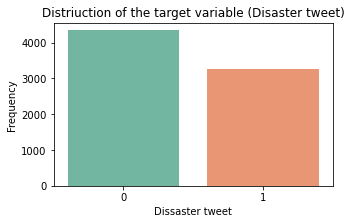

In [28]:
plt.figure(figsize=(5,3))
sns.countplot(data=train, x='target', palette="Set2")

plt.xlabel("Dissaster tweet")
plt.ylabel("Frequency")
plt.title("Distriuction of the target variable (Disaster tweet)")
plt.show()

As we can see, the target variable is a little bit imbalanced, but no that much

In [176]:
print('Num of unique words in train before cleaning:')
print(len(train['text'].str.split().explode().unique()))

Num of unique words in train before cleaning:
31924


In [178]:
print('Num of unique words in test before cleaning:')
print(len(test['text'].str.split().explode().unique()))

Num of unique words in test before cleaning:
17447


Now, I'll analyze the distribution of keyword and location based on target

In [77]:
def plot_dist_by_target(feature):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    train[train['target'] == 1][feature].value_counts().head(10).plot(
        kind='barh', 
        color='darksalmon', 
        fontsize=12,
        ax=axes[0]
    )
    axes[0].set_title(f'Top 10 {feature} of disaster tweets', fontsize=14)
    axes[0].invert_yaxis()
    axes[0].set_xlabel('Count', fontsize=10)


    train[train['target'] == 0][feature].value_counts().head(10).plot(
        kind='barh', 
        color='darkseagreen', 
        fontsize=12,
        ax=axes[1]
    )
    axes[1].set_title(f'Top 10 {feature} of non-disaster tweets', fontsize=14)
    axes[1].invert_yaxis()
    axes[1].set_xlabel('Count', fontsize=10)


    plt.tight_layout() 
    plt.show()

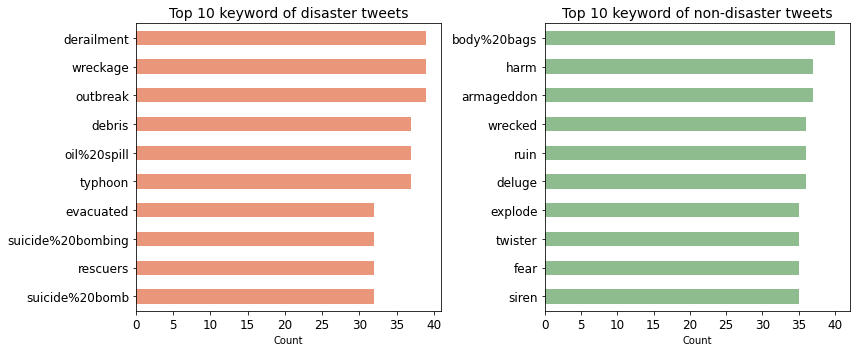

In [78]:
plot_dist_by_target('keyword')

As we can see they are different based on target

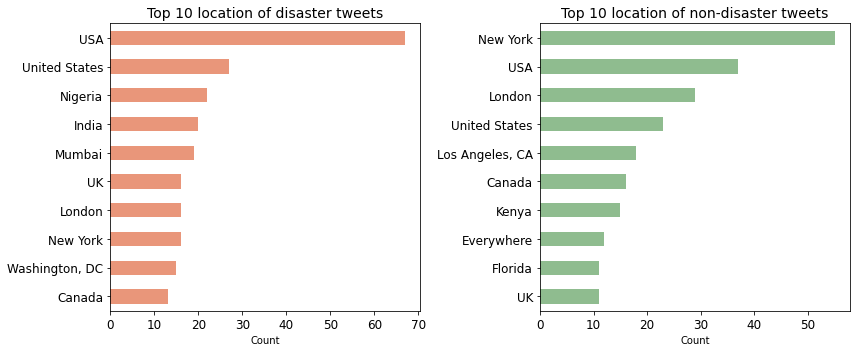

In [80]:
plot_dist_by_target('location')

The difference in location is not that clear

##### Let's see a sample of diaster and non disaster tweets

In [4]:
print('---- Examples of disaster tweets ----')
for tweet in train[train['target'] == 1]['text'].sample(3).values:
    print(tweet)
    print('*'*100)

---- Examples of disaster tweets ----
Lindenow: 3:15pm
Emergency crews are at a chemical spill in the main street near Church Street
****************************************************************************************************
Sharp rise in women children casualties in Afghan war UN says http://t.co/0CXm5TkZ8y http://t.co/v5aMDOvHOT
****************************************************************************************************
Men escape car engulfed in flames in Parley's Canyon crews investigating cause - http://t.co/YfAVSuOgvl http://t.co/ISI1rLLCt0
****************************************************************************************************


In [6]:
print('---- Examples of non disaster tweets ----')
for tweet in train[train['target'] == 0]['text'].sample(3).values:
    print(tweet)
    print('*'*100)

---- Examples of non disaster tweets ----
That horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time.
****************************************************************************************************
@Chemical_Babe its a family emergency so I can't make it unless I have a chance to use by phone for stream.
****************************************************************************************************
@nagel_ashley @Vicken52 @BasedLaRock @goonc1ty rip the world... its burning
****************************************************************************************************


It's clear that we need to perform text preprocessing to clean the text

##### Word cloud based on target
Let's generate a wordcloud based on target for the tween in order to see some patterns

In [86]:
from wordcloud import WordCloud

In [161]:
def generate_wordcloud(data, top_n, target_class):
    count_of_words = data.str.split().explode().value_counts()
    # Only show the top n most frequent words
    count_of_words = count_of_words[0:top_n]
    count_of_words_dict =  {
        count_of_words.index[i]: count_of_words.values[i] for i in range(len(count_of_words))}
    wordcloud = WordCloud(
        width=800, height=400
        ,background_color='white').generate_from_frequencies(count_of_words_dict)
    
    plt.figure(figsize=(12, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Top most {top_n} frequent words in {target_class} class')
    plt.axis('off')
    plt.show()


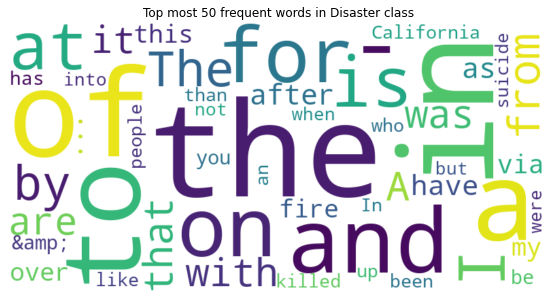

In [162]:
generate_wordcloud(train[train['target'] == 1]['text'], 50, 'Disaster')

We can see some interest words related to diaster like: fire

But, we have a lot of stopwords, after quitting those
I'll plot again in order to see the difference.

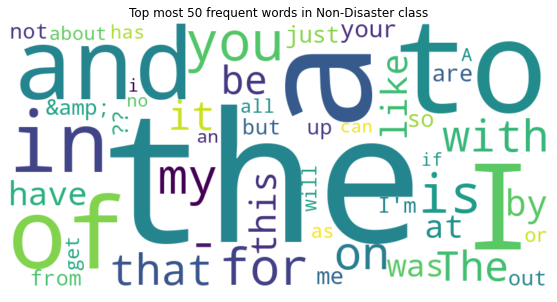

In [163]:
generate_wordcloud(train[train['target'] == 0]['text'], 50, 'Non-Disaster')

## Feature engineering
I was inspired by this article from https://www.analyticsvidhya.com/blog/2021/04/a-guide-to-feature-engineering-in-nlp/
In which they build some features based on the text like:
- Number of words
- Number of characters
- Counts of punctuation
- Counts of capital words


Then, we can count also:

- Number of mentions @
- Number of links https

In [5]:
import re

In [6]:
def count_capital_chars(text):
    count = 0
    for i in text:
        if i.isupper():
            count += 1
    return count

def count_htags(text):
    x = re.findall(r'(#w[A-Za-z0-9]*)', text)
    return len(x) 

def count_mentions(text):
    x = re.findall(r'(@w[A-Za-z0-9]*)', text)
    return len(x)

def count_punctuations(text):
    punctuations='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'
    d=dict()
    for i in punctuations:
        d[str(i)+' count'] = text.count(i)
    return d 

def count_urls(text):
    urls = re.findall(r'(https?://\S+|www\.\S+)', text)
    return len(urls)

In [7]:
def feature_engineering(data):
    data['number_of_words'] = data['text'].apply(lambda x: len(str(x).split()))
    data['number_of_chars'] = data['text'].apply(lambda x: len(str(x)))
    data['count_capital_chars'] = data["text"].apply(lambda x: count_capital_chars(x))
    data['count_htags'] = data["text"].apply(lambda x: count_htags(x))
    data['count_mentions'] = data["text"].apply(lambda x: count_mentions(x))
    data['count_punctuations'] = data["text"].apply(lambda x: count_punctuations(x))
    data['count_urls'] = data["text"].apply(lambda x: count_urls(x))
    
    return data
    

In [8]:
train = feature_engineering(train)

In [9]:
test = feature_engineering(test)

Feature distribution based on target

In [10]:
train.groupby('target')[['number_of_words',
       'number_of_chars', 'count_capital_chars', 'count_htags',
       'count_mentions', 'count_urls']].mean()

,number_of_words,number_of_chars,count_capital_chars,count_htags,count_mentions,count_urls
target,,,,,,
0,14.704744,95.706817,9.209351,0.006449,0.006679,0.507600
1,15.167533,108.113421,10.870682,0.011312,0.003669,0.770101


We can conclude the following:
- Disaster tweets have more number of:
    - Words
    - Characters
    - Capital characteres
    - Hashtags
    - URL's
- Disaster tweets have less number of:
    - Mentions

## Data cleaning

In [11]:
import json

# Contraction map
with open("data/contraction_map.json", "r") as f:
    CONTRACTION_MAP = json.load(f)

The contraction map is a dictionary with contractions in english, for example:

In [16]:
CONTRACTION_MAP["couldn't"]

'could not'

In [13]:
import re
import string
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

STOPWORDS = set(stopwords.words('english'))
wnl = WordNetLemmatizer()


def clean_tweet(text):
    """
    Convert:
    - URLs, mentios and hashtags → special tokens
    - Eliminate stop words
    - Apply lemmatizier
    """
    text = str(text)

    # Special tokems
    text = re.sub(r'https?://\S+|www\.\S+', 'URL', text)
    text = re.sub(r'@\w+', 'MENTION', text)
    text = re.sub(r'#(\w+)', 'HASHTAG', text)

    # Identify emojis with the emoji library
    text = emoji.replace_emoji(text, replace='EMOJI')

    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'&[a-z]+;', '', text)

    # To lower
    text = text.lower()

    # Expand contractions:
    # Example: Convert y'all're to you all are
    words = text.split()
    expanded_words = []
    for word in words:
        if word in CONTRACTION_MAP:
            expanded_words.extend(CONTRACTION_MAP[word].split())
        else:
            expanded_words.append(word)

    # Reduce repeated words
    expanded_words = [re.sub(r'([a-z])\1{2,}', r'\1\1', w) for w in expanded_words]

    # Remove stop words: Example: quit 'the', 'is', 'a'
    # Lematize: 'Running' becomes 'run'
    clean_words = [wnl.lemmatize(w) for w in expanded_words if w not in STOPWORDS]

    # Join all the words together again
    clean_text = ' '.join(clean_words)
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()

    return clean_text


[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [14]:
# Apply the clean tweet fuction to train and test
train['text_after_cleaning'] = train['text'].apply(clean_tweet)
test['text_after_cleaning'] = test['text'].apply(clean_tweet)

In [17]:
print('Num of unique words in train and test after cleaning:')
print(len(
    pd.concat(
        [train['text_after_cleaning'], test['text_after_cleaning']]
    ).str.split().explode().unique()))

Num of unique words in train and test after cleaning:
22578


We can se that after cleanig the text the cloud of words makes more sense than before, as now we have more words related to disasters in the disaster word cloud.

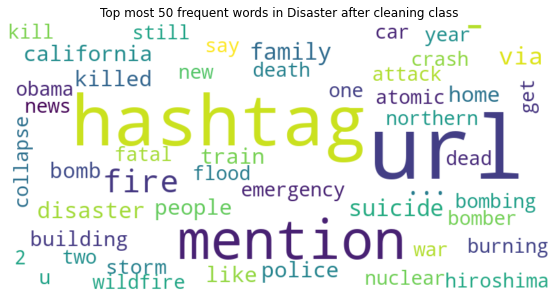

In [168]:
generate_wordcloud(train[train['target'] == 1]['text_after_cleaning'], 50,
                   'Disaster after cleaning')

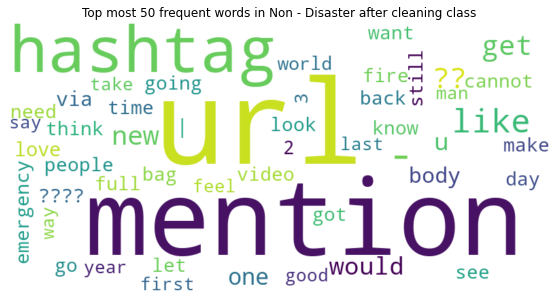

In [166]:
generate_wordcloud(train[train['target'] == 0]['text_after_cleaning'], 50,
                   'Non - Disaster after cleaning')

## Train / Test split

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_val, y_train, y_val = train_test_split(
    train, train['target'],  test_size=0.2, random_state=102) 

In [20]:
print('Samples for training:', X_train.shape[0])
print('Samples for validation:', X_val.shape[0])

Samples for training: 6090
Samples for validation: 1523


### Tokenizer

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [22]:
# Initialize the Tokenizer class
# Let's use 22,571 as is the number of unique words in train + test
tokenizer = Tokenizer(num_words=22571 , split=' ', oov_token='<OOV>')


In [23]:
# Fit the tokenizer to training data
tokenizer.fit_on_texts(X_train['text_after_cleaning']) 
# Save the tokenizer word index
word_index = tokenizer.word_index

This is the mapping that the tokenizer does. See the first 10 elements.
As we can see is a mapping between words and numbers.

In [24]:
list(word_index.items())[0:10]

[('<OOV>', 1),
 ('url', 2),
 ('hashtag', 3),
 ('mention', 4),
 ('like', 5),
 ('fire', 6),
 ('get', 7),
 ('u', 8),
 ('new', 9),
 ('2', 10)]

In [25]:
# Now tokenize the train, test and val text data
train_seq = tokenizer.texts_to_sequences(
    X_train['text_after_cleaning'].values)
val_seq = tokenizer.texts_to_sequences(
    X_val['text_after_cleaning'].values)
test_seq = tokenizer.texts_to_sequences(
    test['text_after_cleaning'].values)

In [26]:
print('First three elements of the tokens sequences in train:')
for i in range(0, 3):
    print(i, train_seq[i])

First three elements of the tokens sequences in train:
0 [49, 969, 216, 256, 1617, 1851, 1459, 217, 1051, 5087, 216, 2186, 2, 3]
1 [4, 1052, 159, 361]
2 [181, 2187, 744, 5088, 481, 1852, 227, 195, 13, 337, 291, 3440, 1053, 19, 2]


Now, we can analyze that the lenght of each sequence is different.
The RNN, LSTM or GRU models needs the same lenght for each sequence, so, we need to pad the sequences in order to have the same lenght for each sequence.

In [27]:
train_padded = pad_sequences(train_seq)

After padding, all the sequences have the same lenght

In [28]:
print('First three elements of the padded tokens sequences in train:')
for i in range(0, 3):
    print(i, train_padded[i])

First three elements of the padded tokens sequences in train:
0 [   0    0    0    0    0    0    0    0    0    0    0    0   49  969
  216  256 1617 1851 1459  217 1051 5087  216 2186    2    3]
1 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    4 1052  159  361]
2 [   0    0    0    0    0    0    0    0    0    0    0  181 2187  744
 5088  481 1852  227  195   13  337  291 3440 1053   19    2]


Now let's pad the validation and testing sequences

In [29]:
length_sequences = train_padded[0].shape[0]

In [30]:
print('Sequence length:', length_sequences)

Sequence length: 26


In [31]:
val_padded = pad_sequences(val_seq, maxlen=length_sequences, truncating='post')
test_padded = pad_sequences(test_seq,maxlen=length_sequences, truncating='post')

### Preprocessing the engineered features

In [32]:
engineered_features = ['number_of_words', 'number_of_chars', 'count_capital_chars',
                      'count_htags', 'count_mentions', 'count_punctuations',
                      'count_urls']
X_train[engineered_features].head(2)

,number_of_words,number_of_chars,count_capital_chars,count_htags,count_mentions,count_punctuations,count_urls
5261,17,136,17,0,0,"{'! count': 0, '"" count': 0, '# count': 1, '$ ...",1
6891,6,44,24,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",0


In [33]:
def preprocess_engineered_features(data, features):
    X = data[features].copy()
    # As count_punctuations is a list of count of each punctuation
    # we need to convert it into a dataframe.
    punct_cols = X['count_punctuations'].iloc[0].keys()
    punct_df = X['count_punctuations'].apply(pd.Series)
    
    X = pd.concat(
        [X.drop(columns=['count_punctuations']), punct_df], axis=1)
    return X

In [34]:
X_train_engineered_features = preprocess_engineered_features(X_train, engineered_features)
X_val_engineered_features = preprocess_engineered_features(X_val, engineered_features)
X_test_engineered_features = preprocess_engineered_features(test, engineered_features)

In [35]:
X_train_engineered_features.head()

,number_of_words,number_of_chars,count_capital_chars,count_htags,count_mentions,count_urls,! count,""" count",# count,$ count,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
5261,17,136,17,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6891,6,44,24,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1036,19,139,12,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1652,6,44,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6528,7,34,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


I will quit features with low frequency.

In [36]:
frequency_features = X_train_engineered_features.sum() / X_train_engineered_features.shape[0]

In [37]:
frequency_features[frequency_features>=0.1]

number_of_words         14.875862
number_of_chars        100.910509
count_capital_chars      9.849097
count_urls               0.622167
! count                  0.157471
# count                  0.438588
- count                  0.234319
. count                  1.535632
/ count                  1.924138
: count                  0.908374
? count                  0.410345
@ count                  0.363218
_ count                  0.110509
dtype: float64

In [38]:
final_engineered_features = list(frequency_features[frequency_features>=0.1].index)

In [39]:
X_train_engineered_features = X_train_engineered_features[final_engineered_features]
X_val_engineered_features = X_val_engineered_features[final_engineered_features]
X_test_engineered_features = X_test_engineered_features[final_engineered_features]

Now, standarize the features

In [40]:
from sklearn.preprocessing import StandardScaler

In [41]:
scaler = StandardScaler()
X_train_engineered_features = scaler.fit_transform(X_train_engineered_features)

In [42]:
X_val_engineered_features = scaler.transform(X_val_engineered_features)
X_test_engineered_features = scaler.transform(X_test_engineered_features)

## Embedding
I'll use GloVe to transform the words into embeddigs. Specifically I'll use the pretrained on twitter data, which can be downloaded at: https://nlp.stanford.edu/projects/glove/

- GloVe is a method to represent words into embedding vectors, so we can have a numerical representation for each word. 


- It was trained on a large corpus of data (in this case data from twitter) and captures how words appear together in context: words that frequently co-occur with similar sets of words will have similar embeddings.

- The training is based on a co-occurrence matrix, which counts how often each pair of words appears within a defined context window. For example, consider the sentence:

    - "I like deep learning so much, this class is excellent for learning theory and practicing at the same time."

    - If the context window is 1, the word “deep” appears next to “like” and “learning”. So in the co-occurrence matrix, the row for “deep” and the column for “learning” would have a value of 1, representing that this pair appears together once within the window.
- After training, the resulting word vectors place similar words close together in the embedding space


In [152]:
# Load GloVe
embedding_index = {}
with open(
    'glove.twitter.27B.200d.txt', 'r',
    encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

Now embedding_index has the mapping between words and the embedding vector

In [154]:
len(embedding_index)

1193514

Embedding index is a dictionary of 1,193,514 words, but, I'll filter in order to only have the words in this particular twitter disaster dataset

In [45]:
# Let's see
embedding_index['diaster'][0:10]

array([-0.44401 ,  0.065343, -0.089002, -0.039676, -0.40053 ,  0.091233,
        0.18323 , -0.48417 ,  0.29151 , -0.31964 ], dtype=float32)

In [46]:
embedding_index['diaster'].shape

(200,)

In [47]:
EMBEDDING_DIM = 200 # This is the embedding vector size of the GloVe model
vocab_size = len(tokenizer.word_index) + 1

In [48]:
vocab_size

12187

Here I contruct my embedding matrix for only the words in the vocabulary for this problem

In [49]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    vector = embedding_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector

In [50]:
embedding_matrix.shape

(12187, 200)

In [51]:
del embedding_index

### Preparing the data for training with Pytorch

In [52]:
import torch
from torch.utils.data import Dataset

In [53]:
class DisasterTweetDataset(Dataset):
    def __init__(self, embeddings, engineered_features, labels):
        # Here we save the embeddings
        self.embeddings = embeddings
        self.engineered_features = engineered_features
        self.labels = labels

    # This is a method that every pytorch dataset class neds to have
    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        embs = torch.tensor(self.embeddings[idx], dtype=torch.long)
        features = torch.tensor(self.engineered_features[idx], dtype=torch.float)
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return embs, features, label


In [54]:
from torch.utils.data import DataLoader

In [55]:
# Create the datasets with the Pytorch class
train_dataset = DisasterTweetDataset(train_padded, X_train_engineered_features, y_train.values)
val_dataset = DisasterTweetDataset(val_padded, X_val_engineered_features, y_val.values)

In [56]:
# And define the DataLoaders, which are batches of the data
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## Model architecture
I'll try two architectures:
- Simple: Using only the embeddings
- Combined: Using embeddings + engineered features (Number of characters, number of words, etc)

Then, the winning one will be tuned with Optuna.

I’ll use an LSTM because it can capture the relationships and context between words in a tweet. By combining word embeddings with an LSTM, the model can process the sequence of words and output a probability that indicates whether the tweet is related to a disaster.

While a basic RNN can process sequences, it often struggles to capture long-range dependencies due to vanishing gradients. An LSTM overcomes this by remembering important information over longer sequences, making it more suitable for classifying disaster-related tweets where key words may be far apart.

In [57]:
import torch.nn as nn

In [102]:
class SimpleLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, lstm_hidden=128, dropout=0.3, bidirectional=False):
        super(SimpleLSTM, self).__init__()
        
        # Here we obtain the vocab size x embedding dimension = (12187, 200)
        num_embeddings, embedding_dim = embedding_matrix.shape

        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        # here we replace the weights with the current GloVe representation
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        # we don't need to tune it.
        self.embedding.weight.requires_grad = False

        # LSTM: Input: 200, output: lstm_hidden
        # Bidirectional False, means that the LSTM will not have information about past and future words
        # only the past information
        self.lstm = nn.LSTM(embedding_dim, lstm_hidden, batch_first=True, bidirectional=bidirectional)
        # Add dropout
        self.lstm_dropout = nn.Dropout(dropout)

        # Output layer
        if bidirectional:
            input_last_layer = lstm_hidden * 2
        else:
            input_last_layer = lstm_hidden
        self.fc = nn.Sequential(
            nn.Linear(input_last_layer, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
            # Sigmoid for binary classification
            nn.Sigmoid()
        )

    def forward(self, embs):
        x = self.embedding(embs)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # last hidden state
        x = self.lstm_dropout(x)

        # Appli the last sequencial layer
        out = self.fc(x)
        return out

In [70]:
class CombinedLSTM(nn.Module):
    def __init__(self, embedding_matrix, engineered_features_input_dim, hidden_dim=128, lstm_hidden=128, dropout=0.3):
        super(CombinedLSTM, self).__init__()
        
        # Here we obtain the vocab size x embedding dimension = (12187, 200)
        num_embeddings, embedding_dim = embedding_matrix.shape

        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        # here we replace the weights with the current GloVe representation
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        # we don't need to tune it.
        self.embedding.weight.requires_grad = False

        # LSTM: Input: 200, output: lstm_hidden
        # Bidirectional True, means that the LSTM will have information about past and future words
        self.lstm = nn.LSTM(embedding_dim, lstm_hidden, batch_first=True, bidirectional=True)
        # Add dropout
        self.lstm_dropout = nn.Dropout(dropout)

        # Engineered features: This part is for the engineered features
        self.engineered_features = nn.Sequential(
            nn.Linear(engineered_features_input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # Combined layers
        self.fc = nn.Sequential(
            # lstm_hidden x 2 because we have a bidirectional LSTM
            # + 32 as the output of the engineered_features sequencial
            nn.Linear(lstm_hidden*2 + 32, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, embs, features):
        x = self.embedding(embs)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # last hidden state
        x = self.lstm_dropout(x)

        engineered_features_out = self.engineered_features(features)
        # Combine the LSTM output + feature engineered output
        combined = torch.cat((x, engineered_features_out), dim=1)
        # Appli the last sequencial layer
        out = self.fc(combined)
        return out


In [61]:
import torch.optim as optim

Define simple model

In [72]:
simple_model = SimpleLSTM(embedding_matrix)
loss_function_simple_model = nn.BCELoss()
optimizer_simple_model = torch.optim.Adam(simple_model.parameters(), lr=0.0001)

# This scheduler to adjust the learning rate as the model is training
scheduler_simple_model = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_simple_model, mode='max', factor=0.5, patience=2, min_lr=1e-5
)

Define the combined model

In [89]:
combined_model = CombinedLSTM(embedding_matrix, X_train_engineered_features.shape[1])
loss_function_combined_model = nn.BCELoss()
optimizer_combined_model = torch.optim.Adam(combined_model.parameters(), lr=0.0001)

# This scheduler to adjust the learning rate as the model is training
scheduler_combined_model = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_combined_model, mode='max', factor=0.5, patience=2, min_lr=1e-5
)

## Model training

In [64]:
from sklearn.metrics import roc_auc_score, f1_score
import torch

In [65]:
device = 'cpu'

In [66]:
def training_model_disaster(num_epochs, optimizer, model, loss_function, scheduler, model_save_path, model_type):
    # This is the value to store the best validation AUC and save the best model
    best_val_f1 = -1.0
    # Iterate all the data in each epoch
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        # In this part, it iterates over each batch
        for embs, features, labels in train_loader:
            embs, features, labels = embs.to(device), features.to(device), labels.to(device)
            # Set gradients to zero, because Pytorch acumulates the previous ones.
            optimizer.zero_grad()
            # If the model is the simple one, only needs the embeddings
            if model_type == 'simple':
                outputs = model(embs).squeeze()
            else:
                outputs = model(embs, features).squeeze()
            # calculate the loss
            loss = loss_function(outputs, labels)
            # Calculate the gradients respect to the loss
            loss.backward()
            # Finally update the parameters based on the gradients calculated with loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for embs, features, labels in val_loader:
                embs, features, labels = embs.to(device), features.to(device), labels.to(device)
                # If the model is the simple one, only needs the embeddings
                if model_type == 'simple':
                    outputs = model(embs).squeeze()
                else:
                    outputs = model(embs, features).squeeze()
                loss = loss_function(outputs, labels)
                val_loss += loss.item()

                all_labels.append(labels.cpu())
                all_probs.append(outputs.cpu())

        val_loss = val_loss / len(val_loader.dataset)
        all_labels = torch.cat(all_labels).numpy()
        all_probs = torch.cat(all_probs).numpy()

        # Threshold 0.5 for binary classification
        preds_binary = [1 if p >= 0.5 else 0 for p in all_probs]

        val_f1 = f1_score(all_labels, preds_binary)
        val_auc = roc_auc_score(all_labels, all_probs)

        print(f"Validation Loss: {val_loss:.4f}, F1-score: {val_f1:.4f}, AUC: {val_auc:.4f}")

        # Save the best model parameters
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), model_save_path)
            print(f"Best model saved with F1-score: {best_val_f1:.4f}")

        # Update the learning rate with the scheduler
        scheduler.step(val_f1)



Training simple LSTM model

In [73]:
training_model_disaster(
    num_epochs=20, optimizer=optimizer_simple_model, model=simple_model,
    loss_function=loss_function_simple_model, scheduler=scheduler_simple_model,
    model_save_path='models/best_simple_model_LSTM.pth', model_type='simple')

Epoch 1/20, Training Loss: 0.0107
Validation Loss: 0.0104, F1-score: 0.2513, AUC: 0.6941
Best model saved with F1-score: 0.2513
Epoch 2/20, Training Loss: 0.0095
Validation Loss: 0.0083, F1-score: 0.7152, AUC: 0.8240
Best model saved with F1-score: 0.7152
Epoch 3/20, Training Loss: 0.0076
Validation Loss: 0.0075, F1-score: 0.7406, AUC: 0.8519
Best model saved with F1-score: 0.7406
Epoch 4/20, Training Loss: 0.0072
Validation Loss: 0.0073, F1-score: 0.7388, AUC: 0.8548
Epoch 5/20, Training Loss: 0.0070
Validation Loss: 0.0072, F1-score: 0.7465, AUC: 0.8581
Best model saved with F1-score: 0.7465
Epoch 6/20, Training Loss: 0.0068
Validation Loss: 0.0071, F1-score: 0.7554, AUC: 0.8614
Best model saved with F1-score: 0.7554
Epoch 7/20, Training Loss: 0.0067
Validation Loss: 0.0071, F1-score: 0.7484, AUC: 0.8619
Epoch 8/20, Training Loss: 0.0067
Validation Loss: 0.0071, F1-score: 0.7536, AUC: 0.8636
Epoch 9/20, Training Loss: 0.0066
Validation Loss: 0.0072, F1-score: 0.7337, AUC: 0.8615
Epoc

Let's load the best simple model

In [75]:
simple_model = SimpleLSTM(embedding_matrix)
simple_model.load_state_dict(torch.load("models/best_simple_model_LSTM.pth"))

<All keys matched successfully>

Let's plot the AUC and F1 score

In [76]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [78]:
def calculate_probability(model, data_loader, model_type):
    '''
    Model: The model to calculate the probability
    data_loader: The data batches, train or validation
    '''
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for embs, features, labels in data_loader:
            embs, features, labels = embs.to(device), features.to(device), labels.to(device)
            # If the model is the simple one, only needs the embeddings
            if model_type == 'simple':
                outputs = model(embs).squeeze()
            else:
                outputs = model(embs, features).squeeze()
            all_labels.append(labels.cpu())
            all_probs.append(outputs.cpu())
    all_labels = torch.cat(all_labels).numpy()
    all_probs = torch.cat(all_probs).numpy()
    return all_labels, all_probs

In [132]:
train_labels, train_probs = calculate_probability(
    simple_model, train_loader, 'simple')
val_labels, val_probs = calculate_probability(
    simple_model, val_loader, 'simple')

In [133]:
def plot_auc_f1(train_labels, train_probs, val_labels, val_probs, title):

    train_fpr, train_tpr, _ = roc_curve(train_labels, train_probs)
    val_fpr, val_tpr, _ = roc_curve(val_labels, val_probs)

    train_preds_binary = [1 if p >= 0.5 else 0 for p in train_probs]
    train_f1 = f1_score(train_labels, train_preds_binary)

    val_preds_binary = [1 if p >= 0.5 else 0 for p in val_probs]
    val_f1 = f1_score(val_labels, val_preds_binary)

    train_auc = auc(train_fpr, train_tpr)
    val_auc = auc(val_fpr, val_tpr)

    # Plot the AUC
    plt.figure(figsize=(8,6))
    plt.plot(train_fpr, train_tpr, label=f'Train AUC = {train_auc:.4f}), F1: {train_f1:.4f}')
    plt.plot(val_fpr, val_tpr, label=f'Validation AUC = {val_auc:.4f}),  F1: {val_f1:.4f}')
    plt.plot([0,1], [0,1], 'k--')  # diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

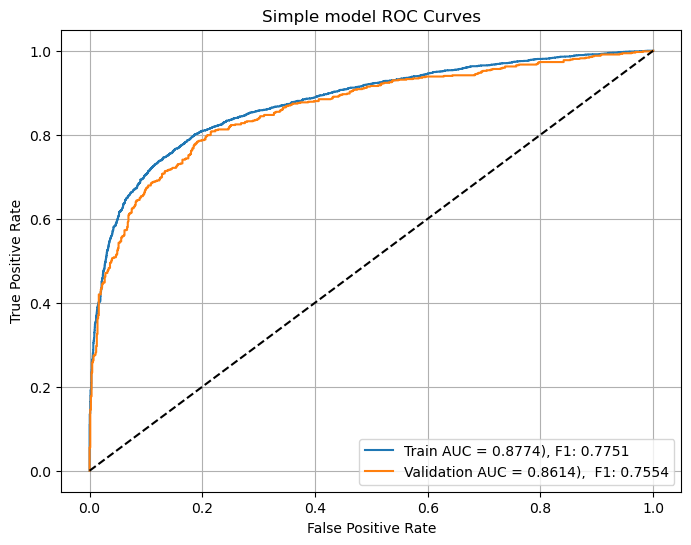

In [134]:
plot_auc_f1(train_labels, train_probs, val_labels, val_probs, title='Simple model ROC Curves')

Train the combined LSTM model

In [90]:
training_model_disaster(
    num_epochs=20, optimizer=optimizer_combined_model, model=combined_model,
    loss_function=loss_function_combined_model, scheduler=scheduler_combined_model,
    model_save_path='models/best_combined_model_LSTM.pth', model_type='combined')

Epoch 1/20, Training Loss: 0.0106
Validation Loss: 0.0102, F1-score: 0.5423, AUC: 0.7097
Best model saved with F1-score: 0.5423
Epoch 2/20, Training Loss: 0.0093
Validation Loss: 0.0083, F1-score: 0.6764, AUC: 0.8267
Best model saved with F1-score: 0.6764
Epoch 3/20, Training Loss: 0.0075
Validation Loss: 0.0075, F1-score: 0.7395, AUC: 0.8542
Best model saved with F1-score: 0.7395
Epoch 4/20, Training Loss: 0.0071
Validation Loss: 0.0073, F1-score: 0.7476, AUC: 0.8600
Best model saved with F1-score: 0.7476
Epoch 5/20, Training Loss: 0.0069
Validation Loss: 0.0072, F1-score: 0.7502, AUC: 0.8631
Best model saved with F1-score: 0.7502
Epoch 6/20, Training Loss: 0.0068
Validation Loss: 0.0071, F1-score: 0.7419, AUC: 0.8642
Epoch 7/20, Training Loss: 0.0067
Validation Loss: 0.0071, F1-score: 0.7506, AUC: 0.8662
Best model saved with F1-score: 0.7506
Epoch 8/20, Training Loss: 0.0066
Validation Loss: 0.0071, F1-score: 0.7620, AUC: 0.8664
Best model saved with F1-score: 0.7620
Epoch 9/20, Tra

Load the best combined model

In [91]:
combined_model = CombinedLSTM(embedding_matrix, X_train_engineered_features.shape[1])
combined_model.load_state_dict(torch.load("models/best_combined_model_LSTM.pth"))

<All keys matched successfully>

In [135]:
train_labels, train_probs = calculate_probability(
    combined_model, train_loader, 'combined')
val_labels, val_probs = calculate_probability(
    combined_model, val_loader, 'combined')

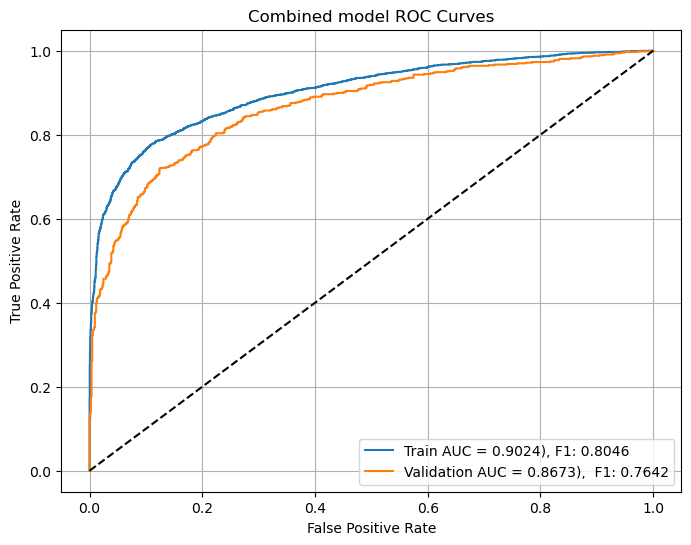

In [136]:
plot_auc_f1(train_labels, train_probs, val_labels, val_probs, title='Combined model ROC Curves')

The combined model looks better in the following terms:
- Higher validation F1 Score
- Higher validation AUC

So, I'll choose the combined architecture to do parameter tuning.

# Hyperparameter tuning
Here, I'll use the combined model architecture and tune the following hyperparameters:
- Dropout propotion
- Learning rate
- LSTM hidden units
- Units in the fully conected layer, the last one to prediction


I'll be using optuna is an open-source Python library designed for automatic hyperparameter optimization.
You can learn more about Optuna here: 
https://optuna.readthedocs.io/en/stable/

In [137]:
import optuna

In [138]:
def objective(trial):

    # Hyperparameter space
    lstm_hidden = trial.suggest_categorical('lstm_hidden', [64, 128, 256])
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256])
    dropout = trial.suggest_float('dropout', 0.2, 0.6)
    lr = trial.suggest_float('lr', 1e-4, 1e-3, log=True)
   
    # Model definition based on hyperparameters
    model = CombinedLSTM(
        embedding_matrix, X_train_engineered_features.shape[1],
        hidden_dim=hidden_dim, lstm_hidden=lstm_hidden, dropout=dropout)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.BCELoss()

    # Train only with 5 epochs
    for epoch in range(5):
        model.train()
        # In this part, it iterates over each batch
        for embs, features, labels in train_loader:
            embs, features, labels = embs.to(device), features.to(device), labels.to(device)
            # Set gradients to zero, because Pytorch acumulates the previous ones.
            optimizer.zero_grad()
            outputs = model(embs, features).squeeze()
            # calculate the loss
            loss = loss_function(outputs, labels)
            # Calculate the gradients respect to the loss
            loss.backward()
            # Finally update the parameters based on the gradients calculated with loss.backward()
            optimizer.step()
    
    val_labels, val_probs = calculate_probability(
        model, val_loader, 'combined')

    val_preds_binary = [1 if p >= 0.5 else 0 for p in val_probs]
    val_f1 = f1_score(val_labels, val_preds_binary)

    return val_f1 # Maximize F1 Score


In [139]:
# Use optuna for hyperparameter tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2025-11-01 20:22:43,205] A new study created in memory with name: no-name-c2158df1-8f7d-4087-96d2-744322842400
[I 2025-11-01 20:22:53,980] Trial 0 finished with value: 0.7423363711681856 and parameters: {'lstm_hidden': 256, 'hidden_dim': 64, 'dropout': 0.3408470338132989, 'lr': 0.0005774695742840151}. Best is trial 0 with value: 0.7423363711681856.
[I 2025-11-01 20:23:00,137] Trial 1 finished with value: 0.7398843930635838 and parameters: {'lstm_hidden': 128, 'hidden_dim': 256, 'dropout': 0.3266651464879769, 'lr': 0.00011032007363854459}. Best is trial 0 with value: 0.7423363711681856.
[I 2025-11-01 20:23:04,613] Trial 2 finished with value: 0.7476190476190476 and parameters: {'lstm_hidden': 64, 'hidden_dim': 128, 'dropout': 0.5849709254078606, 'lr': 0.00044062170656528966}. Best is trial 2 with value: 0.7476190476190476.
[I 2025-11-01 20:23:08,979] Trial 3 finished with value: 0.7609531129900077 and parameters: {'lstm_hidden': 64, 'hidden_dim': 128, 'dropout': 0.3366160278841725, '

In [140]:
print("Best hyperparameters:", study.best_params)
print("Best F1 Score:", study.best_value)

Best hyperparameters: {'lstm_hidden': 128, 'hidden_dim': 256, 'dropout': 0.22194559166167616, 'lr': 0.0005280169287679885}
Best F1 Score: 0.764797507788162


Now that we have the best hyperparameters, let's define the model architecture with those and train it with more epochs.

In [141]:
tunned_model = CombinedLSTM(
        embedding_matrix, X_train_engineered_features.shape[1],
        hidden_dim=256, lstm_hidden=128, dropout=0.22194559166167616)
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(tunned_model.parameters(), lr=0.0005280169287679885)

# This scheduler to adjust the learning rate as the model is training
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, min_lr=1e-5
)

In [142]:
training_model_disaster(
    num_epochs=40, optimizer=optimizer, model=tunned_model,
    loss_function=loss_function, scheduler=scheduler,
    model_save_path='models/best_tuned_model_LSTM.pth', model_type='combined')

Epoch 1/40, Training Loss: 0.0086
Validation Loss: 0.0072, F1-score: 0.7457, AUC: 0.8615
Best model saved with F1-score: 0.7457
Epoch 2/40, Training Loss: 0.0069
Validation Loss: 0.0071, F1-score: 0.7359, AUC: 0.8643
Epoch 3/40, Training Loss: 0.0066
Validation Loss: 0.0070, F1-score: 0.7512, AUC: 0.8692
Best model saved with F1-score: 0.7512
Epoch 4/40, Training Loss: 0.0062
Validation Loss: 0.0070, F1-score: 0.7419, AUC: 0.8714
Epoch 5/40, Training Loss: 0.0059
Validation Loss: 0.0071, F1-score: 0.7475, AUC: 0.8668
Epoch 6/40, Training Loss: 0.0057
Validation Loss: 0.0073, F1-score: 0.7570, AUC: 0.8617
Best model saved with F1-score: 0.7570
Epoch 7/40, Training Loss: 0.0054
Validation Loss: 0.0074, F1-score: 0.7627, AUC: 0.8682
Best model saved with F1-score: 0.7627
Epoch 8/40, Training Loss: 0.0052
Validation Loss: 0.0074, F1-score: 0.7442, AUC: 0.8604
Epoch 9/40, Training Loss: 0.0048
Validation Loss: 0.0081, F1-score: 0.7539, AUC: 0.8601
Epoch 10/40, Training Loss: 0.0044
Validati

In [143]:
tunned_model = CombinedLSTM(
        embedding_matrix, X_train_engineered_features.shape[1],
        hidden_dim=256, lstm_hidden=128, dropout=0.22194559166167616)
tunned_model.load_state_dict(torch.load("models/best_tuned_model_LSTM.pth"))

<All keys matched successfully>

In [144]:
train_labels, train_probs = calculate_probability(
    tunned_model, train_loader, 'combined')
val_labels, val_probs = calculate_probability(
    tunned_model, val_loader, 'combined')

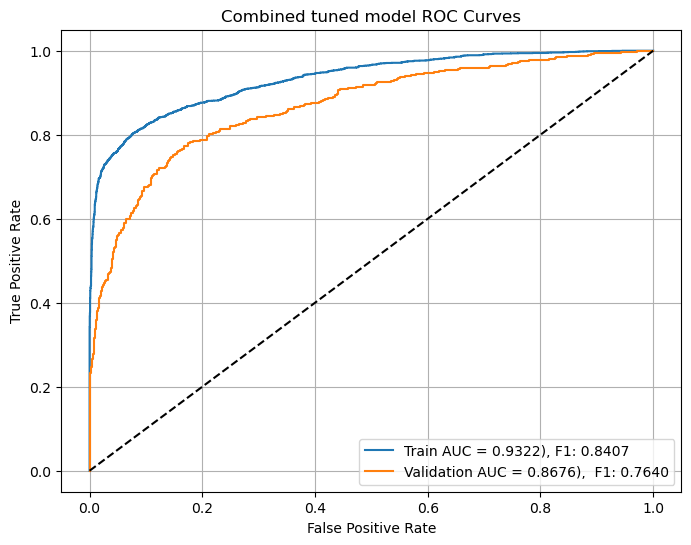

In [145]:
plot_auc_f1(train_labels, train_probs, val_labels, val_probs, title='Combined tuned model ROC Curves')

# Test data for leaderboard
Now, let's predict the probability for the test data

In [115]:
test_dataset = DisasterTweetDataset(test_padded, X_test_engineered_features, 
    labels=[0]*len(test_padded) # Dummy labels
)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [129]:
def obtain_test_predictions(model, model_type):
    val_labels, val_probs = calculate_probability(
        model, val_loader, model_type)
    best_model_threshold = find_best_threshold(val_labels, val_probs)
    
    model.eval()
    all_preds = []

    with torch.no_grad():
        for embs, features, _ in test_loader:
            embs, features = embs.to(device), features.to(device)
            if model_type == 'simple':
                outputs = model(embs).squeeze()
            else:
                outputs = model(embs, features).squeeze()
            all_preds.extend(outputs.cpu().numpy())

    preds_binary = [1 if p >= 0.5 else 0 for p in all_preds]
    return preds_binary

##### Simple model

In [126]:
predictions_simple_model = obtain_test_predictions(simple_model, 'simple')
submission_simple_model = pd.DataFrame({
    "id": test['id'].values,
    "target": predictions_simple_model
})

submission_simple_model.to_csv("data/submission_simple_model.csv", index=False)

##### Combined model

In [149]:
predictions_combined_model = obtain_test_predictions(combined_model, 'combined')
submission_combined_model = pd.DataFrame({
    "id": test['id'].values,
    "target": predictions_combined_model
})

submission_combined_model.to_csv("data/submission_combined_model.csv", index=False)

##### Tuned model

In [150]:
predictions_tuned_model = obtain_test_predictions(tunned_model, 'combined')
submission_tuned_model = pd.DataFrame({
    "id": test['id'].values,
    "target": predictions_tuned_model
})

submission_tuned_model.to_csv("data/submission_tuned_model.csv", index=False)

After passing the test set in LeaderBoard at Kaggle I obtained the following public scores:
- Simple model:
    - Public score: 0.7790
- Combined model:
    - Public score: 0.7977
- Tuned model:
    - Public score: 0.7983

# Conclusion
- Is better using an combined architecture for this problem than a simpler one
- It's useful doing feature engineering with the text data
- The model with hyperparameter tuning is better

# Next steps:
- Optimize the architecture, trying to adjust the trial function in Optuna to change the architecture
- Try more epochs in the hyperparameter optimization, rather than 5
- Try more n_trials, I used 20
- Do more feature engineering
- Use the keyword as feature
- Try all the engineered features, as I discarted those with low frequency


#### References
- https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained
- https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
- https://nlp.stanford.edu/projects/glove/
- https://www.analyticsvidhya.com/blog/2021/04/a-guide-to-feature-engineering-in-nlp/